In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

In [5]:
working_dir = '/Users/gt/nnlpcache/' #"/om2/user/ckauf/.result_caching/neural_nlp.score"

In [6]:
filename='passagesplit_backup/benchmark=Pereira2018-encoding-scrambled-original-passagesplit,model=distilgpt2,subsample=None.pkl'

In [7]:
file = os.path.join(working_dir,filename)
with open(file, 'rb') as f:
    out = pickle.load(f)
result = out['data'].values

/opt/anaconda3/lib/python3.8/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


Loading lookup from /opt/anaconda3/lib/python3.8/site-packages/brainio_collection/lookup.csv


## Investigate score object and store raw scores ##

In [8]:
result

array([[1.37437591, 0.08091395],
       [3.10412828, 0.00886134],
       [3.10951617, 0.0076946 ],
       [3.11421647, 0.00767451],
       [3.11081817, 0.01043125],
       [3.10788003, 0.01237772],
       [3.09983621, 0.01381036]])

In [9]:
s = out['data']
s

<xarray.Score (layer: 7, aggregation: 2)>
array([[1.374376, 0.080914],
       [3.104128, 0.008861],
       [3.109516, 0.007695],
       [3.114216, 0.007675],
       [3.110818, 0.010431],
       [3.10788 , 0.012378],
       [3.099836, 0.01381 ]])
Coordinates:
  * layer        (layer) object 'drop' 'encoder.h.0' ... 'encoder.h.5'
  * aggregation  (aggregation) <U6 'center' 'error'
Attributes:
    raw:          <xarray.Score (layer: 7, aggregation: 2)>\narray([[0.437831...
    ceiling:      <xarray.Score (aggregation: 3)>\narray([0.318567, 0.012958,...
    description:  ceiling-normalized score
    model:        distilgpt2
    benchmark:    Pereira2018-encoding-scrambled-original-passagesplit

In [10]:
lang_raw = s.raw.raw # contains raw scores across layers, for each neuroid
lang_raw

<xarray.Score (layer: 7, neuroid: 13517)>
array([[0.392655, 0.408495, 0.389756, ..., 0.475   , 0.463549, 0.464572],
       [0.9897  , 0.991165, 0.992329, ..., 0.986368, 0.987445, 0.995212],
       [0.986935, 0.98548 , 0.987359, ..., 0.976309, 0.981603, 0.994431],
       ...,
       [0.993054, 0.994677, 0.992314, ..., 0.992272, 0.990857, 0.995073],
       [0.989621, 0.990959, 0.986686, ..., 0.988249, 0.988401, 0.994021],
       [0.969931, 0.981181, 0.970476, ..., 0.981232, 0.983354, 0.984778]])
Coordinates:
  * layer            (layer) object 'drop' 'encoder.h.0' ... 'encoder.h.5'
  * neuroid          (neuroid) MultiIndex
  - subject          (neuroid) object '018' '018' '018' ... '018' '018' '018'
  - voxel_num        (neuroid) int64 28 29 31 32 38 42 ... 152 153 154 159 160
  - filter_strategy  (neuroid) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
  - atlas_selection  (neuroid) object 'from90to100prcnt' ... 'from90to100prcnt'
  - roi              (neuroid) object 'LH_AntTemp' 'L

In [11]:
all_raw = s.raw.raw.raw # contains scores for all neuroids, across all layers, across expts and splits
all_raw

<xarray.Score (layer: 7, experiment: 2, split: 5, neuroid: 102880)>
array([[[[0.380643, ..., 0.60309 ],
         ...,
         [0.476423, ..., 0.535647]],

        [[0.346564, ..., 0.367016],
         ...,
         [0.326601, ..., 0.398184]]],


       ...,


       [[[1.      , ..., 1.      ],
         ...,
         [1.      , ..., 1.      ]],

        [[1.      , ..., 1.      ],
         ...,
         [1.      , ..., 1.      ]]]])
Coordinates:
  * layer            (layer) object 'drop' 'encoder.h.0' ... 'encoder.h.5'
  * experiment       (experiment) object '243sentences' '384sentences'
  * neuroid          (neuroid) MultiIndex
  - subject          (neuroid) object '018' '018' '018' ... '018' '018' '018'
  - voxel_num        (neuroid) int64 28 29 31 32 38 42 ... 152 153 154 159 160
  - filter_strategy  (neuroid) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
  - atlas_selection  (neuroid) object 'from90to100prcnt' ... 'from90to100prcnt'
  - roi              (neuroid) object 'LH_An

Investigate the scores for language (already meaned across splits and expt)

In [12]:
lang_raw.shape

(7, 13517)

## Scatter plot of raw language scores across layers

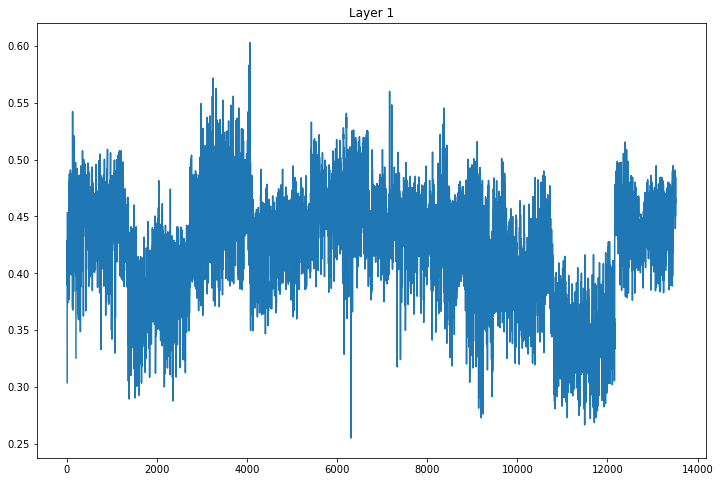

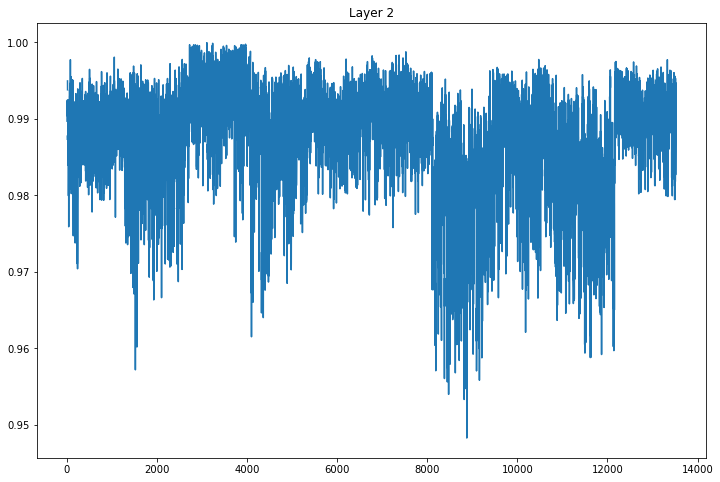

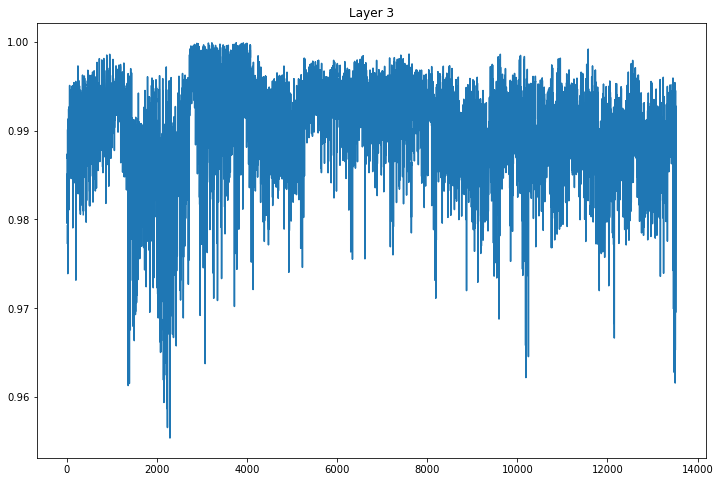

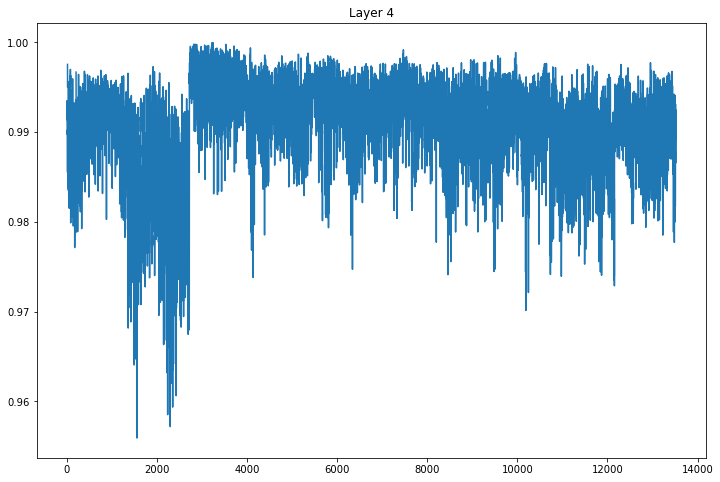

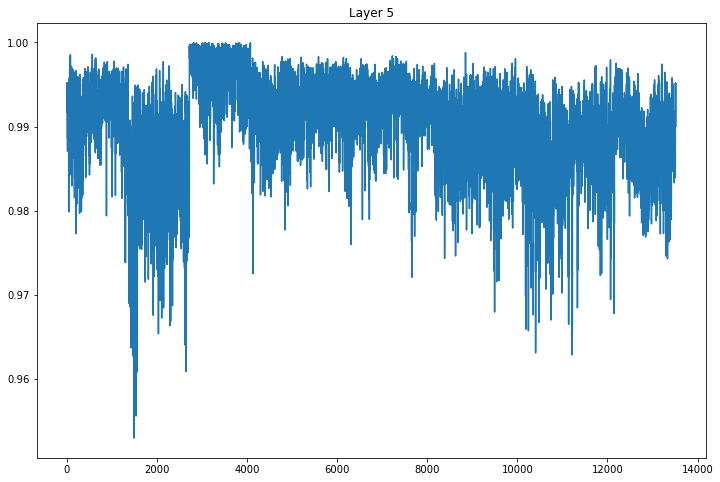

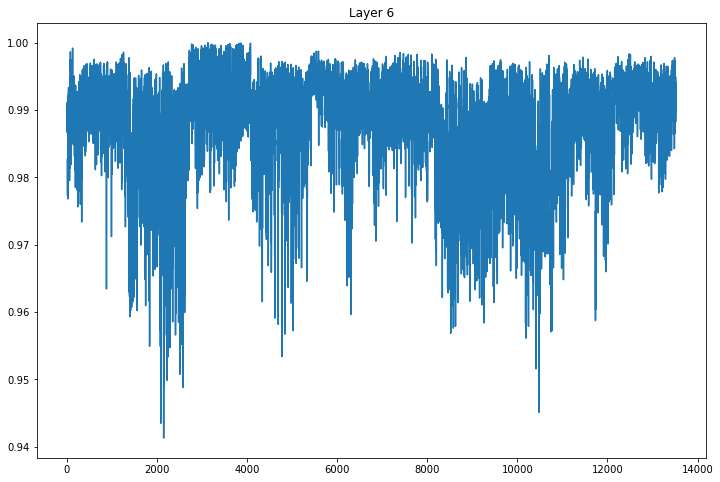

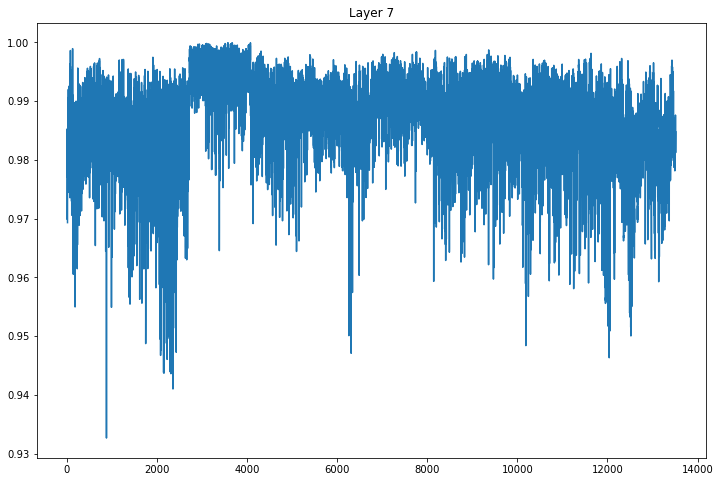

In [13]:
# plot across layers
for l in range(lang_raw.shape[0]):
    plt.figure(figsize=(12,8))
    plt.plot(lang_raw.values[l,:])
    plt.title(f'Layer {l+1}')

## Histogram of raw language scores across layers

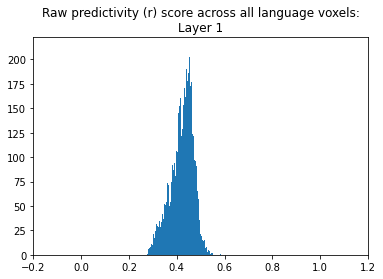

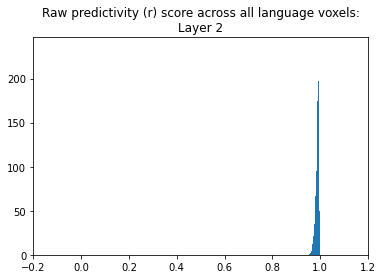

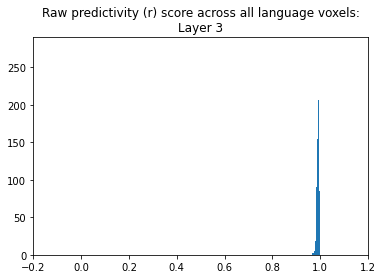

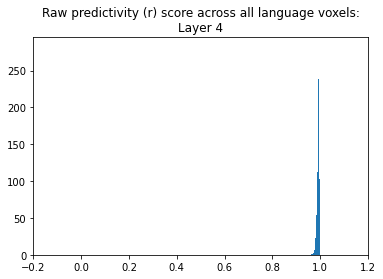

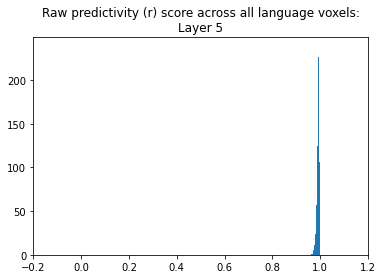

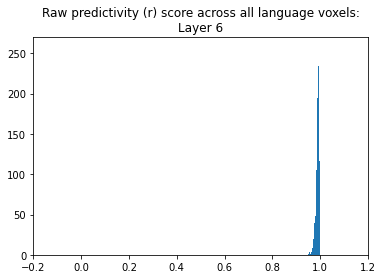

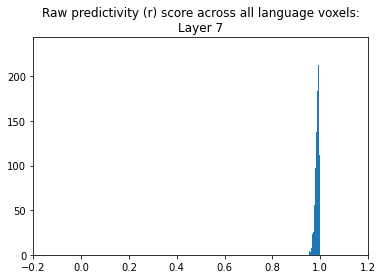

In [16]:
# plot across layers
for l in range(lang_raw.shape[0]):
    plt.figure(figsize=(6,4))
    plt.hist(lang_raw.values[l,:],bins=250)
    plt.xlim([-0.2,1.2])
    plt.title(f'Raw predictivity (r) score across all language voxels:\nLayer {l+1}')

## Investigate various groupings to provide a final score

In [17]:
# perform grouping:
lang_raw.loc[lang_raw.layer == 'encoder.h.5'].groupby('subject').median().median()


/opt/anaconda3/lib/python3.8/site-packages/xarray/core/groupby.py:638: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  return self.reduce(func, dim, axis, keep_attrs=keep_attrs,


<xarray.Score ()>
array(0.987505)

Divide by (approximate) ceiling

In [19]:
0.987505/0.32 # matches with the final score reported in the 'result'

3.0859531249999996

How does the score change by mean operations?

In [17]:
lang_raw.loc[lang_raw.layer == 'encoder.h.5'].groupby('subject').mean().median()

/opt/anaconda3/lib/python3.8/site-packages/xarray/core/groupby.py:638: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  return self.reduce(func, dim, axis, keep_attrs=keep_attrs,


<xarray.Score ()>
array(0.103598)

In [18]:
lang_raw.loc[lang_raw.layer == 'encoder.h.5'].groupby('subject').mean().mean()

/opt/anaconda3/lib/python3.8/site-packages/xarray/core/groupby.py:638: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  return self.reduce(func, dim, axis, keep_attrs=keep_attrs,


<xarray.Score ()>
array(0.11151)

In [19]:
lang_raw.loc[lang_raw.layer == 'encoder.h.5'].groupby('subject').median().mean()

/opt/anaconda3/lib/python3.8/site-packages/xarray/core/groupby.py:638: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  return self.reduce(func, dim, axis, keep_attrs=keep_attrs,


<xarray.Score ()>
array(0.111498)

It actually increases :) i.e. we seem to take the most conservative estimate (in this very particular case)

Obtain neuroids across splits and expt for just lang voxels

In [20]:
all_raw.loc[all_raw.layer == 'encoder.h.5'].squeeze()

<xarray.Score (experiment: 2, split: 5, neuroid: 102880)>
array([[[ 0.23432 ,  0.206656, ..., -0.030995, -0.031156],
        [ 0.075623,  0.299801, ...,  0.286427,  0.344863],
        ...,
        [-0.047588,  0.124971, ..., -0.041289, -0.083486],
        [ 0.134911, -0.011817, ..., -0.189472, -0.151613]],

       [[ 0.285693,  0.228758, ..., -0.069719, -0.05564 ],
        [-0.167308, -0.101419, ...,  0.162996,  0.066657],
        ...,
        [ 0.200168,  0.133275, ...,  0.270719,  0.274235],
        [-0.096314, -0.055349, ...,  0.011397,  0.010256]]])
Coordinates:
    layer            <U11 'encoder.h.5'
  * experiment       (experiment) object '243sentences' '384sentences'
  * neuroid          (neuroid) MultiIndex
  - subject          (neuroid) object '018' '018' '018' ... '018' '018' '018'
  - voxel_num        (neuroid) int64 28 29 31 32 38 42 ... 152 153 154 159 160
  - filter_strategy  (neuroid) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
  - atlas_selection  (neuroid) objec

In [21]:
all_raw.loc[all_raw.layer == 'encoder.h.5'].squeeze().groupby('experiment').mean() # similar scores across expts

/opt/anaconda3/lib/python3.8/site-packages/xarray/core/groupby.py:638: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  return self.reduce(func, dim, axis, keep_attrs=keep_attrs,


<xarray.Score (experiment: 2)>
array([0.11319 , 0.098562])
Coordinates:
    layer       <U11 'encoder.h.5'
  * experiment  (experiment) object '243sentences' '384sentences'

How is the score affected by taking the MEAN across CV splits? OBS this analysis is across ALL neuroids, not only lang

In [22]:
all_raw.loc[all_raw.layer == 'encoder.h.5'].squeeze().groupby('split').mean()

/opt/anaconda3/lib/python3.8/site-packages/xarray/core/groupby.py:638: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  return self.reduce(func, dim, axis, keep_attrs=keep_attrs,


<xarray.Score (split: 5)>
array([0.096872, 0.099638, 0.096105, 0.106797, 0.1222  ])
Coordinates:
    layer    <U11 'encoder.h.5'
  * split    (split) int64 0 1 2 3 4

In [23]:
all_raw.loc[all_raw.layer == 'encoder.h.5'].squeeze().groupby('split').median()

/opt/anaconda3/lib/python3.8/site-packages/xarray/core/groupby.py:638: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  return self.reduce(func, dim, axis, keep_attrs=keep_attrs,


<xarray.Score (split: 5)>
array([0.096827, 0.099701, 0.097175, 0.104797, 0.123335])
Coordinates:
    layer    <U11 'encoder.h.5'
  * split    (split) int64 0 1 2 3 4

In [35]:
x = all_raw.loc[all_raw.layer == 'encoder.h.5'].squeeze()

In [36]:
x

<xarray.Score (experiment: 2, split: 5, neuroid: 102880)>
array([[[ 0.23432 ,  0.206656, ..., -0.030995, -0.031156],
        [ 0.075623,  0.299801, ...,  0.286427,  0.344863],
        ...,
        [-0.047588,  0.124971, ..., -0.041289, -0.083486],
        [ 0.134911, -0.011817, ..., -0.189472, -0.151613]],

       [[ 0.285693,  0.228758, ..., -0.069719, -0.05564 ],
        [-0.167308, -0.101419, ...,  0.162996,  0.066657],
        ...,
        [ 0.200168,  0.133275, ...,  0.270719,  0.274235],
        [-0.096314, -0.055349, ...,  0.011397,  0.010256]]])
Coordinates:
    layer            <U11 'encoder.h.5'
  * experiment       (experiment) object '243sentences' '384sentences'
  * neuroid          (neuroid) MultiIndex
  - subject          (neuroid) object '018' '018' '018' ... '018' '018' '018'
  - voxel_num        (neuroid) int64 28 29 31 32 38 42 ... 152 153 154 159 160
  - filter_strategy  (neuroid) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
  - atlas_selection  (neuroid) objec

Test taking mean over experiment or median over experiment

In [45]:
x.mean(dim='experiment').T.loc[x.atlas == 'language'].groupby('subject').median().median()

/opt/anaconda3/lib/python3.8/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/lib/python3.8/site-packages/xarray/core/groupby.py:638: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  return self.reduce(func, dim, axis, keep_attrs=keep_attrs,


<xarray.Score ()>
array(0.104011)
Coordinates:
    layer    <U11 'encoder.h.5'

In [46]:
x.median(dim='experiment').T.loc[x.atlas == 'language'].groupby('subject').median().median()

/opt/anaconda3/lib/python3.8/site-packages/xarray/core/groupby.py:638: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  return self.reduce(func, dim, axis, keep_attrs=keep_attrs,


<xarray.Score ()>
array(0.104011)
Coordinates:
    layer    <U11 'encoder.h.5'

Score does not change. Using mean across subjects:

In [44]:
x.median(dim='experiment').T.loc[x.atlas == 'language'].groupby('subject').mean().mean()

/opt/anaconda3/lib/python3.8/site-packages/xarray/core/groupby.py:638: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  return self.reduce(func, dim, axis, keep_attrs=keep_attrs,


<xarray.Score ()>
array(0.11151)
Coordinates:
    layer    <U11 'encoder.h.5'

In [47]:
x.mean(dim='experiment').T.loc[x.atlas == 'language'].groupby('subject').mean().mean()

/opt/anaconda3/lib/python3.8/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/anaconda3/lib/python3.8/site-packages/xarray/core/groupby.py:638: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  return self.reduce(func, dim, axis, keep_attrs=keep_attrs,


<xarray.Score ()>
array(0.11151)
Coordinates:
    layer    <U11 'encoder.h.5'

In [48]:
x.mean(dim='experiment')

/opt/anaconda3/lib/python3.8/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Score (split: 5, neuroid: 102880)>
array([[ 0.260007,  0.217707,  0.328831, ..., -0.043128, -0.050357, -0.043398],
       [-0.045842,  0.099191, -0.005821, ...,  0.202493,  0.224712,  0.20576 ],
       [-0.018821,  0.016557, -0.017176, ...,  0.150312,  0.128268,  0.185332],
       [ 0.07629 ,  0.129123,  0.157767, ...,  0.08343 ,  0.114715,  0.095375],
       [ 0.019298, -0.033583,  0.088232, ..., -0.00644 , -0.089037, -0.070679]])
Coordinates:
    layer            <U11 'encoder.h.5'
  * neuroid          (neuroid) MultiIndex
  - subject          (neuroid) object '018' '018' '018' ... '018' '018' '018'
  - voxel_num        (neuroid) int64 28 29 31 32 38 42 ... 152 153 154 159 160
  - filter_strategy  (neuroid) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
  - atlas_selection  (neuroid) object 'from90to100prcnt' ... 'from90to100prcnt'
  - roi              (neuroid) object 'LH_AntTemp' 'LH_AntTemp' ... 'LH_AntTemp'
  - indices_in_3d    (neuroid) int64 72505 72506 72584 ... 877

In [51]:
(x.median(dim='experiment') == x.mean(dim='experiment')).all()

/opt/anaconda3/lib/python3.8/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Score ()>
array(False)
Coordinates:
    layer    <U11 'encoder.h.5'

In [64]:
np.sum(x.median(dim='experiment').values == x.mean(dim='experiment').values)

514305

In [66]:
x.median(dim='experiment').values

array([[ 0.26000685,  0.21770722,  0.32883107, ..., -0.04312756,
        -0.05035704, -0.04339778],
       [-0.04584248,  0.09919116, -0.005821  , ...,  0.20249325,
         0.22471177,  0.20575989],
       [-0.01882141,  0.01655653, -0.01717615, ...,  0.15031187,
         0.12826831,  0.18533228],
       [ 0.07628987,  0.12912295,  0.15776724, ...,  0.08342986,
         0.11471479,  0.09537452],
       [ 0.0192984 , -0.03358291,  0.08823248, ..., -0.00644049,
        -0.08903732, -0.0706787 ]])

In [65]:
x.mean(dim='experiment').values

array([[ 0.26000685,  0.21770722,  0.32883107, ..., -0.04312756,
        -0.05035704, -0.04339778],
       [-0.04584248,  0.09919116, -0.005821  , ...,  0.20249325,
         0.22471177,  0.20575989],
       [-0.01882141,  0.01655653, -0.01717615, ...,  0.15031187,
         0.12826831,  0.18533228],
       [ 0.07628987,  0.12912295,  0.15776724, ...,  0.08342986,
         0.11471479,  0.09537452],
       [ 0.0192984 , -0.03358291,  0.08823248, ..., -0.00644049,
        -0.08903732, -0.0706787 ]])

In [55]:
514305 / (102880*5)

0.9998153188180404

I.e. it is always the same to take mean/median over experiment?

In [56]:
x

<xarray.Score (experiment: 2, split: 5, neuroid: 102880)>
array([[[ 0.23432 ,  0.206656, ..., -0.030995, -0.031156],
        [ 0.075623,  0.299801, ...,  0.286427,  0.344863],
        ...,
        [-0.047588,  0.124971, ..., -0.041289, -0.083486],
        [ 0.134911, -0.011817, ..., -0.189472, -0.151613]],

       [[ 0.285693,  0.228758, ..., -0.069719, -0.05564 ],
        [-0.167308, -0.101419, ...,  0.162996,  0.066657],
        ...,
        [ 0.200168,  0.133275, ...,  0.270719,  0.274235],
        [-0.096314, -0.055349, ...,  0.011397,  0.010256]]])
Coordinates:
    layer            <U11 'encoder.h.5'
  * experiment       (experiment) object '243sentences' '384sentences'
  * neuroid          (neuroid) MultiIndex
  - subject          (neuroid) object '018' '018' '018' ... '018' '018' '018'
  - voxel_num        (neuroid) int64 28 29 31 32 38 42 ... 152 153 154 159 160
  - filter_strategy  (neuroid) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
  - atlas_selection  (neuroid) objec

In [57]:
x.shape

(2, 5, 102880)

In [58]:
x.experiment

<xarray.Score 'experiment' (experiment: 2)>
array(['243sentences', '384sentences'], dtype=object)
Coordinates:
    layer       <U11 'encoder.h.5'
  * experiment  (experiment) object '243sentences' '384sentences'

In [60]:
x.loc[x.experiment=='243sentences']

<xarray.Score (experiment: 1, split: 5, neuroid: 102880)>
array([[[ 0.23432 ,  0.206656, ..., -0.030995, -0.031156],
        [ 0.075623,  0.299801, ...,  0.286427,  0.344863],
        ...,
        [-0.047588,  0.124971, ..., -0.041289, -0.083486],
        [ 0.134911, -0.011817, ..., -0.189472, -0.151613]]])
Coordinates:
    layer            <U11 'encoder.h.5'
  * experiment       (experiment) object '243sentences'
  * neuroid          (neuroid) MultiIndex
  - subject          (neuroid) object '018' '018' '018' ... '018' '018' '018'
  - voxel_num        (neuroid) int64 28 29 31 32 38 42 ... 152 153 154 159 160
  - filter_strategy  (neuroid) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
  - atlas_selection  (neuroid) object 'from90to100prcnt' ... 'from90to100prcnt'
  - roi              (neuroid) object 'LH_AntTemp' 'LH_AntTemp' ... 'LH_AntTemp'
  - indices_in_3d    (neuroid) int64 72505 72506 72584 ... 87754 87831 87832
  - col_to_coord_1   (neuroid) int64 62 63 62 63 63 63 63 ... 65

In [61]:
x.loc[x.experiment=='384sentences']

<xarray.Score (experiment: 1, split: 5, neuroid: 102880)>
array([[[ 0.285693,  0.228758, ..., -0.069719, -0.05564 ],
        [-0.167308, -0.101419, ...,  0.162996,  0.066657],
        ...,
        [ 0.200168,  0.133275, ...,  0.270719,  0.274235],
        [-0.096314, -0.055349, ...,  0.011397,  0.010256]]])
Coordinates:
    layer            <U11 'encoder.h.5'
  * experiment       (experiment) object '384sentences'
  * neuroid          (neuroid) MultiIndex
  - subject          (neuroid) object '018' '018' '018' ... '018' '018' '018'
  - voxel_num        (neuroid) int64 28 29 31 32 38 42 ... 152 153 154 159 160
  - filter_strategy  (neuroid) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
  - atlas_selection  (neuroid) object 'from90to100prcnt' ... 'from90to100prcnt'
  - roi              (neuroid) object 'LH_AntTemp' 'LH_AntTemp' ... 'LH_AntTemp'
  - indices_in_3d    (neuroid) int64 72505 72506 72584 ... 87754 87831 87832
  - col_to_coord_1   (neuroid) int64 62 63 62 63 63 63 63 ... 65